In [1]:
#importing Library

import tensorflow as tf
import numpy as np
import cv2
from imutils.paths import list_images

In [6]:
#path for dataset

path=r"E:\courses\python\sixweekcourse\Abinash Practice\mask detection\dataset"

In [22]:
#assigning size of input image image to 224 * 224 pixels
target_size=(224,224)
dataset=[]

In [23]:
# Inputing images for training

# First of all inputting images of people with mask

for file in list_images(path+r"\with_mask"):
    image=cv2.imread(file)
    image=cv2.resize(image,target_size)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=tf.keras.applications.mobilenet_v2.preprocess_input(image)
    dataset.append(image)

# Inputting images of peaple without mask
for file in list_images(path+r"\without_mask"):
    image=cv2.imread(file)
    image=cv2.resize(image,target_size)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=tf.keras.applications.mobilenet_v2.preprocess_input(image)
    dataset.append(image)
    
    

In [24]:
#converting pixel value to numpy array
dataset=np.array(dataset)

In [25]:
dataset.shape

(1376, 224, 224, 3)

In [26]:
#assigning labels to the image, person wearing mask = 1, person not wearing mask = 0

labels=[1.]*690+[0.]*686
labels=np.array([labels]).T

In [27]:
labels.shape

(1376, 1)

In [56]:

#loading mobile visual recognition architecture

mobnet=tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
mobnet.trainable=False

In [57]:

# Adding Extra Layers in MobileNetV2 architecture

mob_net_output=mobnet.output
y=tf.keras.layers.AveragePooling2D(pool_size=(7,7))(mob_net_output)
y=tf.keras.layers.Flatten()(y)
y=tf.keras.layers.Dense(128,activation="relu")(y)
y=tf.keras.layers.Dropout(0.5)(y)
y=tf.keras.layers.Dense(1,activation="sigmoid")(y)



In [58]:
#grouping layers into an object with training and inference features.
fin_mod=tf.keras.models.Model(inputs=mobnet.input,outputs=y)

In [59]:
# Summary of the fin_mod model
fin_mod.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [70]:
import random

In [73]:
indices=np.arange(1376)
random.shuffle(indices)

In [75]:
dataset=dataset[indices,:,:,:]


In [81]:
labels=labels[indices,:]

In [82]:
from sklearn.model_selection import train_test_split

In [83]:
#splitting data in train and test
trainX,testX,trainY,testY=train_test_split(dataset,labels,test_size=0.22,stratify=labels,random_state=42)

In [87]:
#assigning hyperparameters
Epoch=10
batchsize=32
learning_rate=1e-4

In [88]:


opt=tf.keras.optimizers.Adam(lr=learning_rate, decay=learning_rate/Epoch)

fin_mod.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


In [89]:
#artificially expanding the size of a training dataset by creating modified versions of images in the dataset
aug=tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                    zoom_range=0.15,
                                                    width_shift_range=0.2,
                                                    height_shift_range=0.2,
                                                    shear_range=0.15,
                                                    horizontal_flip=True,
                                                    fill_mode="nearest")

In [90]:
# Training the data
history=fin_mod.fit(aug.flow(trainX,trainY,batch_size=batchsize),
                    steps_per_epoch=len(trainX)//batchsize,
                    validation_data=(testX,testY),
                    validation_steps=len(testX)//batchsize,
                    epochs=Epoch
                   )

Epoch 1/10
33/33 [==============================] - 29s 870ms/step - loss: 0.4139 - accuracy: 0.8229 - val_loss: 0.1259 - val_accuracy: 0.9901
Epoch 2/10
33/33 [==============================] - 24s 729ms/step - loss: 0.1162 - accuracy: 0.9808 - val_loss: 0.0578 - val_accuracy: 0.9901
Epoch 3/10
33/33 [==============================] - 24s 733ms/step - loss: 0.0652 - accuracy: 0.9856 - val_loss: 0.0460 - val_accuracy: 0.9835
Epoch 4/10
33/33 [==============================] - 24s 733ms/step - loss: 0.0417 - accuracy: 0.9933 - val_loss: 0.0374 - val_accuracy: 0.9835
Epoch 5/10
33/33 [==============================] - 28s 851ms/step - loss: 0.0335 - accuracy: 0.9962 - val_loss: 0.0349 - val_accuracy: 0.9835
Epoch 6/10
33/33 [==============================] - 27s 807ms/step - loss: 0.0279 - accuracy: 0.9952 - val_loss: 0.0296 - val_accuracy: 0.9835
Epoch 7/10
33/33 [==============================] - 25s 769ms/step - loss: 0.0265 - accuracy: 0.9923 - val_loss: 0.0247 - val_accuracy: 0.9901

In [91]:
import matplotlib.pyplot as plt

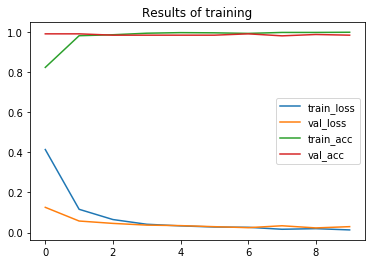

In [95]:
plt.figure()
plt.plot(np.arange(0,Epoch),history.history["loss"],label="train_loss")
plt.plot(np.arange(0,Epoch),history.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,Epoch),history.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,Epoch),history.history["val_accuracy"],label="val_acc")
plt.title("Results of training")
plt.legend()
plt.show()

In [97]:
# Saving The trained model for future use
fin_mod.save("trained_mask.h5")

array([[ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [